# Procesamiento de señal de EMG

##### Importar librerias

In [15]:
import numpy as np
from scipy.signal import firwin, freqz, lfilter, iirfilter, butter, find_peaks
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import sympy

## Señal en reposo

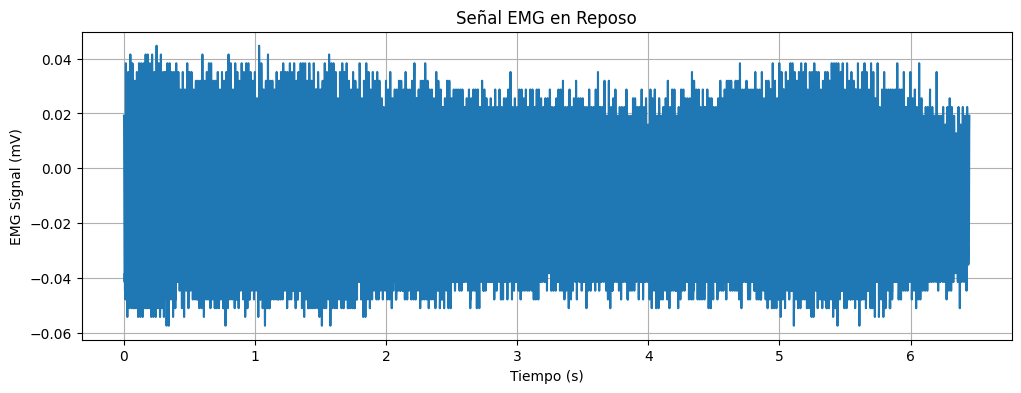

In [16]:
#Se carga la señal
array_reposo = np.genfromtxt("Reposo.txt",delimiter="	",skip_header = 2) 
valores=array_reposo[:,-2]
Fs=1000#Siendo la frecuencia de muestreo del BITalino de 1000 Hz
tiempo=np.arange(0,len(valores))/Fs
valores=(((valores/1024)-0.5)*3.3)/(1009)*1000 #Se convierte la señal a mV
#valores-=np.mean(valores)
plt.figure(figsize=[12,4])
plt.plot(tiempo, valores)
plt.ylabel('EMG Signal (mV)')
plt.xlabel('Tiempo (s)')
plt.title('Señal EMG en Reposo')
plt.grid(True)

La grabación de la señal se grabó dejando unos segundo en reposo la señal y luego se ejerció la fuerza de la tensión, debido a esto se recorta la señal

### Espectro de la señal

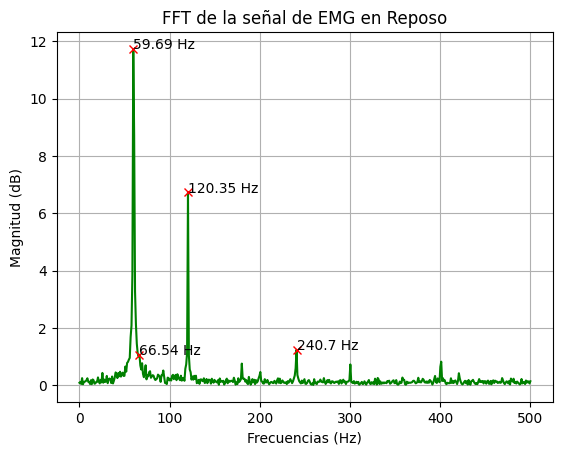

In [17]:
#Debido a que la señal comienza en 4 segundos aproximadamente, se corta la señal en ese punto
valores = valores[4 * Fs:]
tiempo= tiempo[4 * Fs:]
N=2**10 # 10 bits
valores-=np.mean(valores) #Se elimina el componente DC
X1 = np.fft.fft(valores,N)
X1 = X1[0:N//2]
X1m = np.abs(X1)
F = np.linspace(0,Fs/2,N//2)
peaks, properties = find_peaks(X1m, height=1)
plt.plot(F, X1m,'g')
plt.grid()
plt.title("FFT de la señal de EMG en Reposo")
plt.xlabel("Frecuencias (Hz)")
plt.ylabel("Magnitud (dB)")
for i in range(len(peaks)):
    plt.text(F[peaks[i]], properties["peak_heights"][i], f"{np.round(F[peaks[i]], 2)} Hz")
    plt.plot(F[peaks[i]], properties["peak_heights"][i], 'rx')
plt.show()

### Filtros

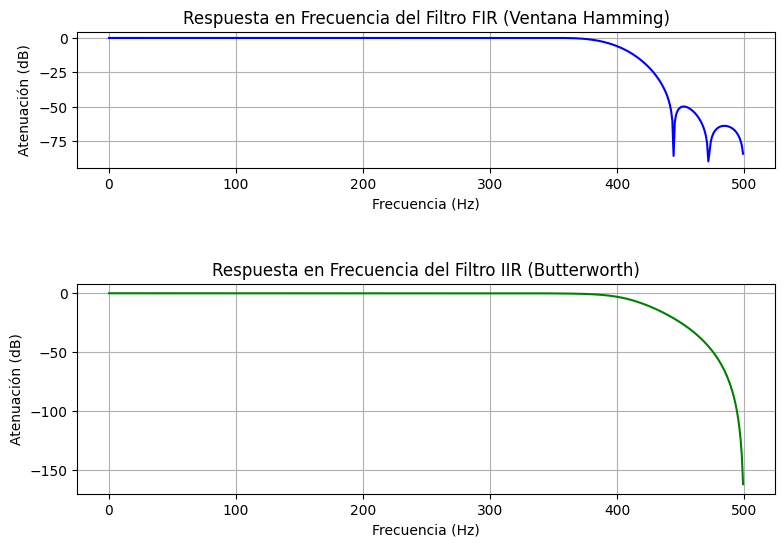

In [18]:
#Filtro FIR
Wn_fir= 0.8 #la frecuencia se encuentra expresada como una fracción de la frecuencia de Nyquist (500Hz) ya que es la mitad de la Fs
Wn_irr= 0.8 #0.8 indica que la frecuencia de corte es 400 Hz
num_taps = 40 #Número de coeficientes del filtro
fir_filter = firwin(num_taps, Wn_fir,window='hamming')
iir_filter = iirfilter(N=4, Wn=Wn_irr, btype='low', ftype='butter')
# Respuesta en frecuencia del filtro FIR (Hamming)
w, h = freqz(fir_filter)
mag_fir = np.abs(h)  # Magnitud de la respuesta del filtro FIR
mag_db_fir = 20 * np.log10(mag_fir)  # Convertir magnitud a dB

plt.figure(figsize=(9, 6))
plt.subplot(3, 1, 1)
plt.plot(0.5*Fs*w/np.pi, mag_db_fir, 'b')  # Graficar la respuesta en frecuencia en dB
plt.title('Respuesta en Frecuencia del Filtro FIR (Ventana Hamming)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Atenuación (dB)')  # Etiqueta del eje y en dB
plt.grid(True)

# Respuesta en frecuencia del filtro IIR (Butterworth)
w, h = freqz(*butter(4, Wn_irr, btype='low'))
mag_iir = np.abs(h)  # Magnitud de la respuesta del filtro IIR
mag_db_iir = 20 * np.log10(mag_iir)  # Convertir magnitud a dB

plt.subplot(2, 1, 2)
plt.plot(0.5*Fs*w/np.pi, mag_db_iir, 'g')  # Graficar la respuesta en frecuencia en dB
plt.title('Respuesta en Frecuencia del Filtro IIR (Butterworth)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Atenuación (dB)')  # Etiqueta del eje y en dB
plt.grid(True)
plt.savefig("Filtros.png")

### Filtrando la señal

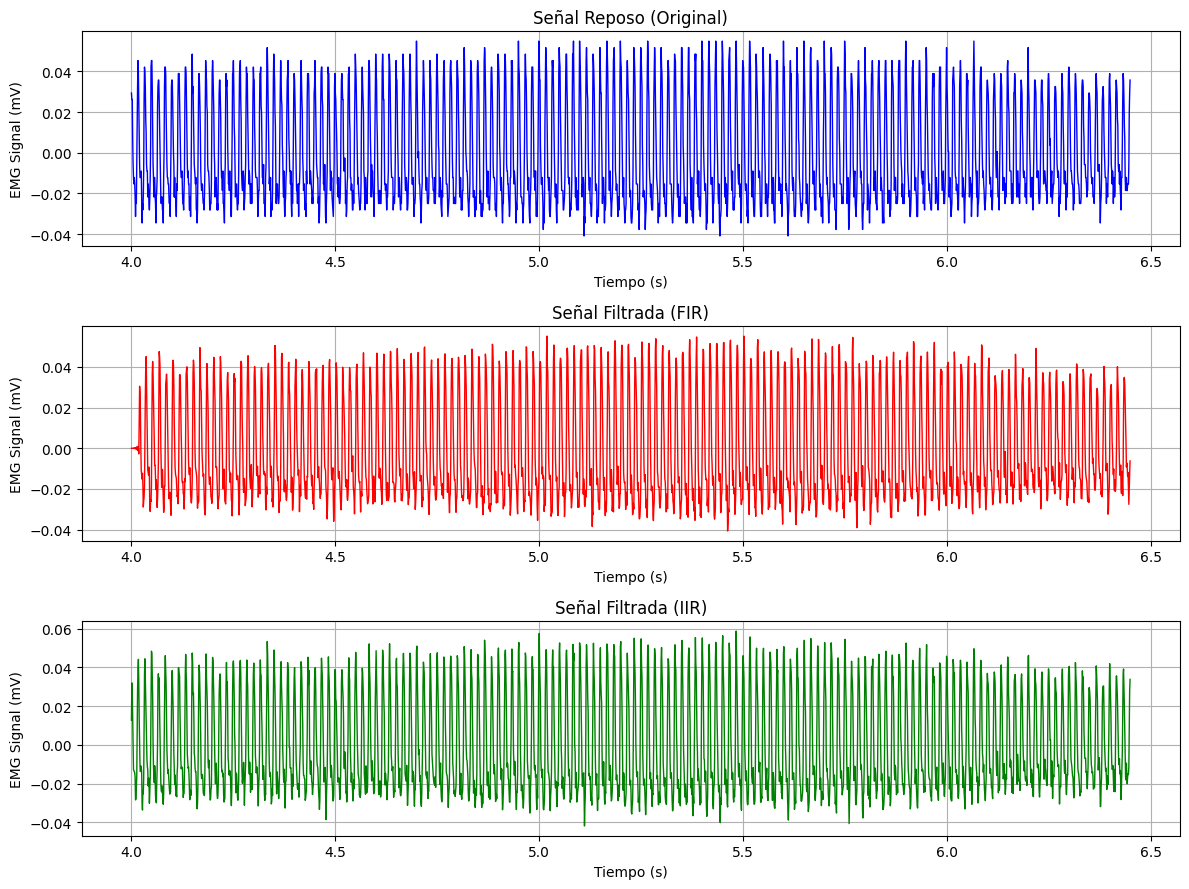

In [19]:
# Aplicar los filtros
fir_emg = lfilter(fir_filter, 1.0, valores)
iir_emg = lfilter(iir_filter[0], iir_filter[1], valores)

plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
plt.plot(tiempo, valores, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('EMG Signal (mV)')
plt.title('Señal Reposo (Original)')
plt.grid(True)


plt.subplot(3, 1, 2)
plt.plot(tiempo, fir_emg, lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('EMG Signal (mV)')
plt.title('Señal Filtrada (FIR)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tiempo, iir_emg, lw=1, color='green')
plt.xlabel('Tiempo (s)')
plt.ylabel('EMG Signal (mV)')
plt.title('Señal Filtrada (IIR)')
plt.grid(True)
plt.tight_layout()
plt.savefig("SeñalReposo.png")
plt.show()


### Comparación en el espectro

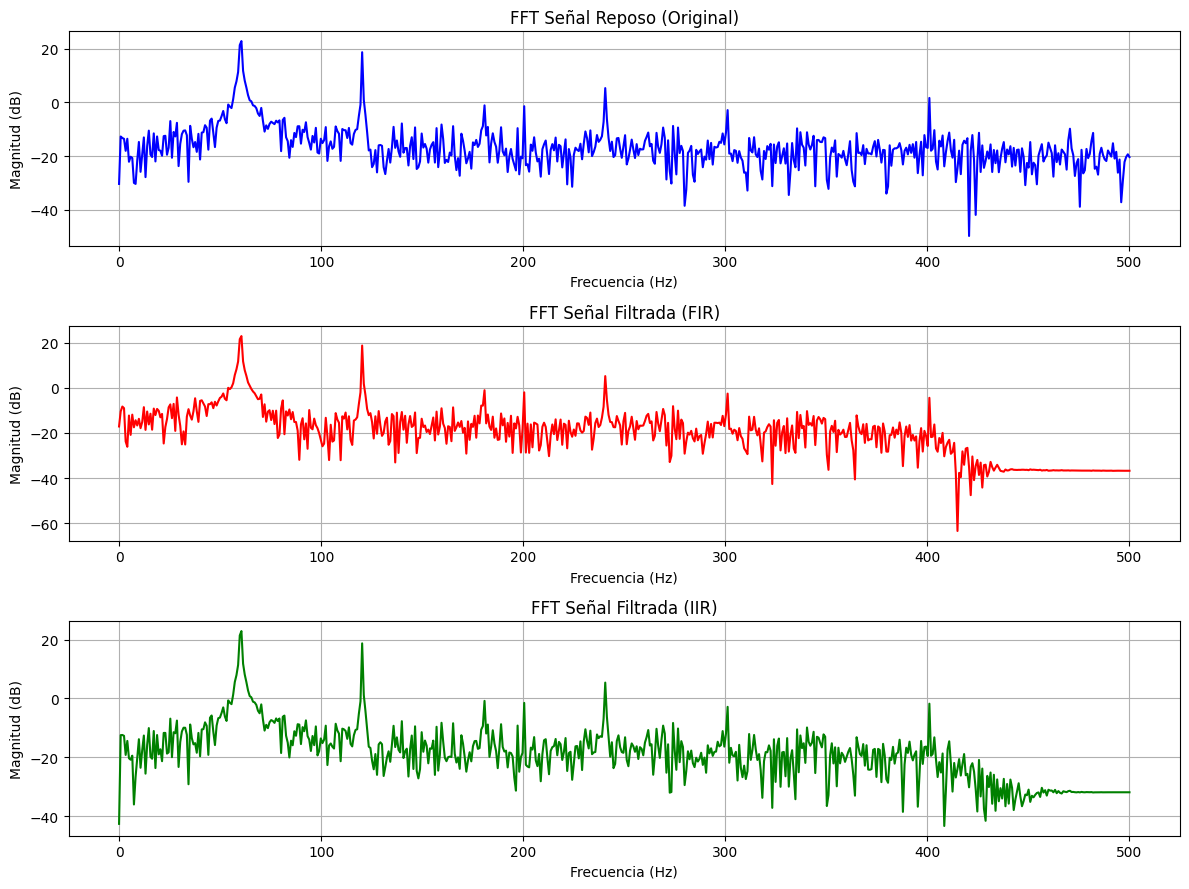

In [20]:

# Aplicar la FFT a la señal original y las señales filtradas
N = len(valores)
X_original = np.fft.fft(valores[N//2:N]) # Solo usaremos la mitad positiva de la FFT
X_original = X_original[:N//4] # Limitamos el rango de frecuencias a la mitad de la FFT
X_original_mag = np.abs(X_original)
F_original = np.linspace(0, Fs/2, len(X_original))

X_fir = np.fft.fft(fir_emg[N//2:N])
X_fir = X_fir[:N//4]
X_fir_mag = np.abs(X_fir)

X_iir = np.fft.fft(iir_emg[N//2:N])
X_iir = X_iir[:N//4]
X_iir_mag = np.abs(X_iir)
# Crear subplots para las FFT de la señal original y las señales filtradas
plt.figure(figsize=(12, 9))
# Subplot para la señal original
plt.subplot(3, 1, 1)
plt.plot(F_original, 20 * np.log10(X_original_mag),color='blue')
plt.title('FFT Señal Reposo (Original)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)
# Subplot para la FFT del FIR Filtro
plt.subplot(3, 1, 2)
plt.plot(F_original, 20 * np.log10(X_fir_mag),color='red')
plt.title('FFT Señal Filtrada (FIR)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

# Subplot para la FFT del IIR Filtro
plt.subplot(3, 1, 3)
plt.plot(F_original, 20 * np.log10(X_iir_mag), color='green')
plt.title('FFT Señal Filtrada (IIR)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()



## Señal en Oposición

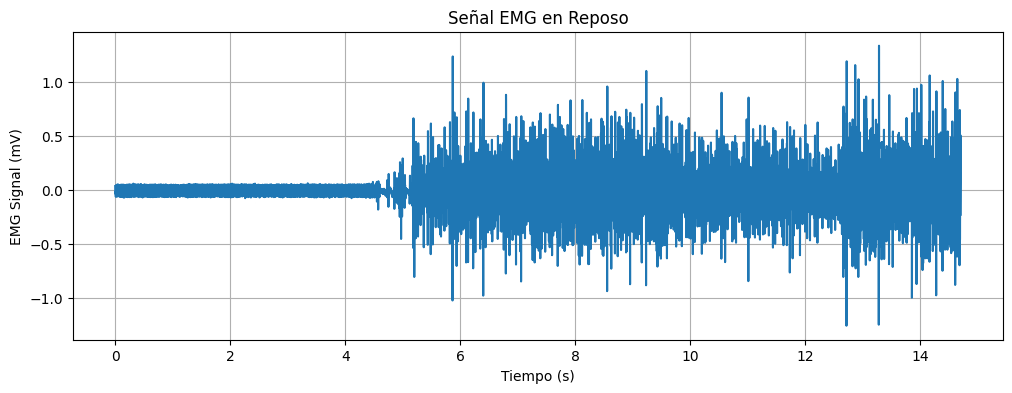

In [21]:
#Se carga la señal
array_reposo = np.genfromtxt("Oposición.txt",delimiter="	",skip_header = 2) 
valores=array_reposo[:,-2]
Fs=1000#Siendo la frecuencia de muestreo del BITalino de 1000 Hz
tiempo=np.arange(0,len(valores))/Fs
valores=(((valores/1024)-0.5)*3.3)/(1009)*1000 #Se convierte la señal a mV
#valores-=np.mean(valores)
plt.figure(figsize=[12,4])
plt.plot(tiempo, valores)
plt.ylabel('EMG Signal (mV)')
plt.xlabel('Tiempo (s)')
plt.title('Señal EMG en Reposo')
plt.grid(True)

La grabación de la señal se grabó dejando unos segundo en reposo la señal y luego se ejerció la fuerza de la oposición, debido a esto se recorta la señal

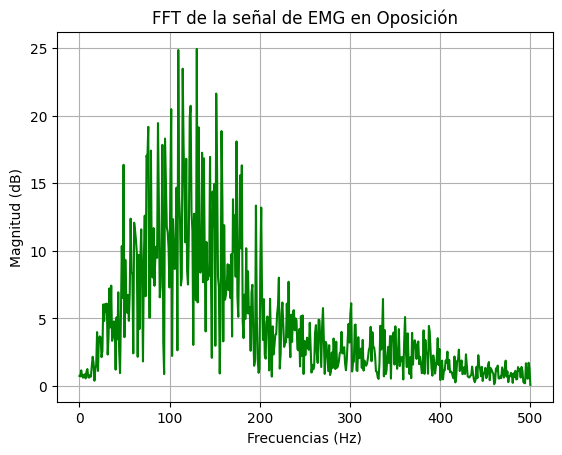

In [22]:
#Debido a que la señal comienza en 6 segundos aproximadamente, se corta la señal en ese punto
valores = valores[6 * Fs:]
tiempo= tiempo[6 * Fs:]
N=2**10 # 10 bits
valores-=np.mean(valores) #Se elimina el componente DC
X1 = np.fft.fft(valores,N)
X1 = X1[0:N//2]
X1m = np.abs(X1)
F = np.linspace(0,Fs/2,N//2)

plt.plot(F, X1m,'g')
plt.grid()
plt.title("FFT de la señal de EMG en Oposición")
plt.xlabel("Frecuencias (Hz)")
plt.ylabel("Magnitud (dB)")
plt.show()

### Filtros

Debido a que la señal es la misma, el rango de frecuencias que se filtran es el mismo, se hace uso del filtro ya creado anteriormente

### Filtrando la señal

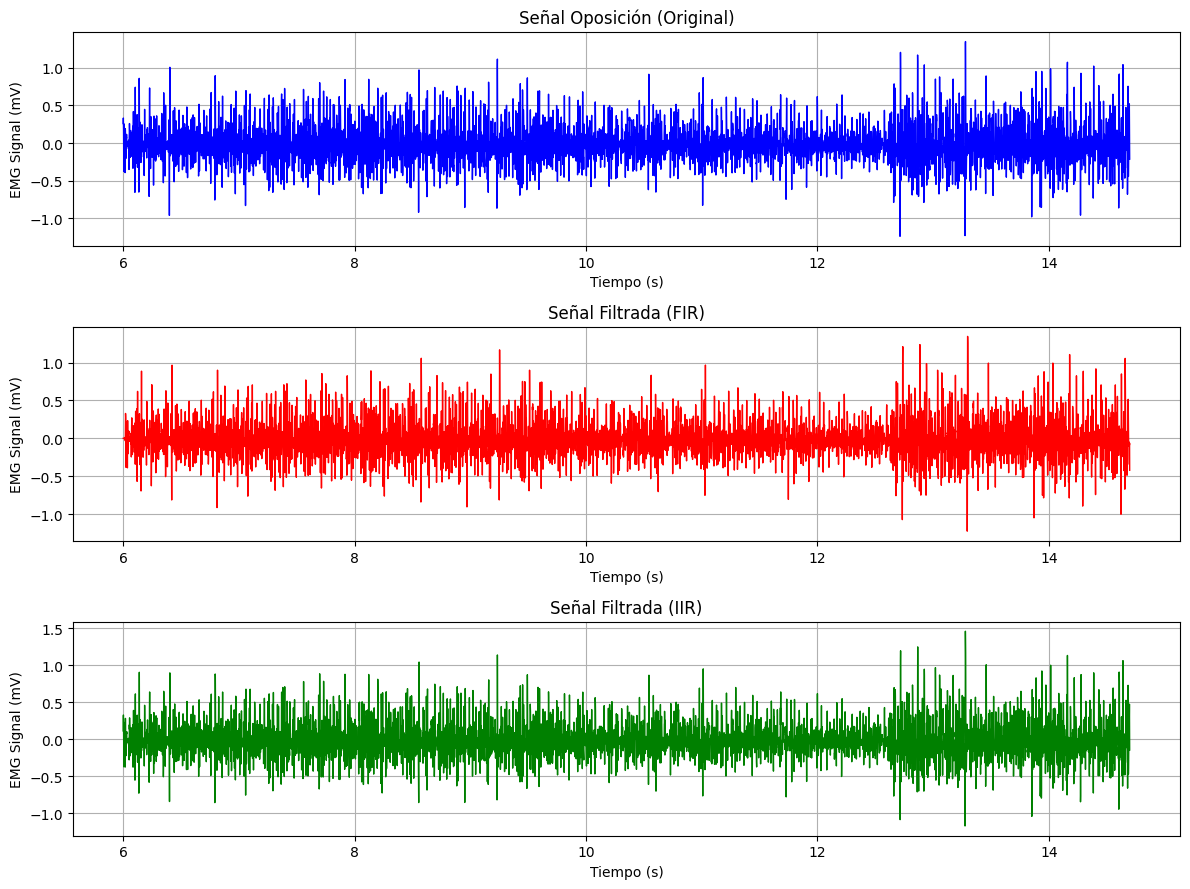

In [23]:
# Aplicar los filtros
fir_emg = lfilter(fir_filter, 1.0, valores)
iir_emg = lfilter(iir_filter[0], iir_filter[1], valores)

plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
plt.plot(tiempo, valores, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('EMG Signal (mV)')
plt.title('Señal Oposición (Original)')
plt.grid(True)


plt.subplot(3, 1, 2)
plt.plot(tiempo, fir_emg, lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('EMG Signal (mV)')
plt.title('Señal Filtrada (FIR)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tiempo, iir_emg, lw=1, color='green')
plt.xlabel('Tiempo (s)')
plt.ylabel('EMG Signal (mV)')
plt.title('Señal Filtrada (IIR)')
plt.grid(True)
plt.tight_layout()
plt.savefig("SeñalOposición.png")
plt.show()

### Comparación en el espectro

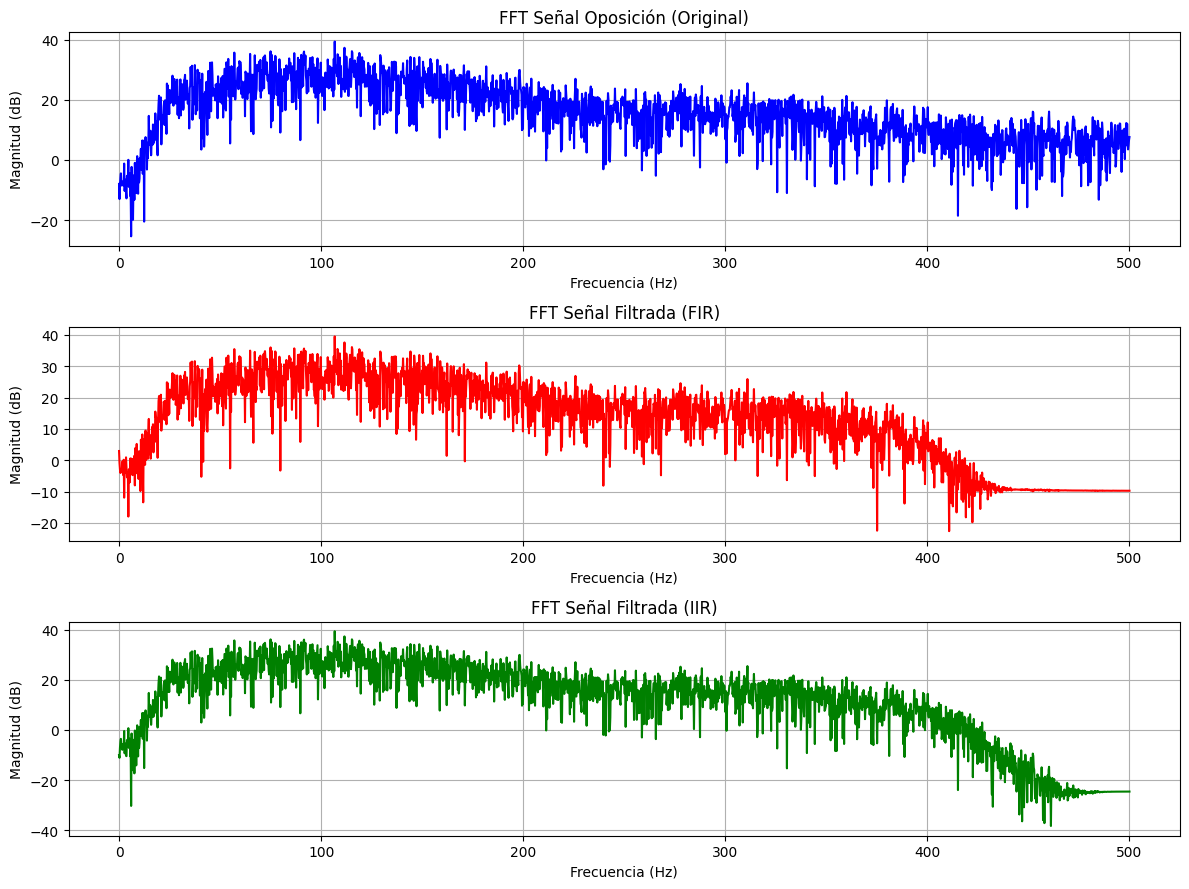

In [24]:
# Aplicar la FFT a la señal original y las señales filtradas
N = len(valores)
X_original = np.fft.fft(valores[N//2:N]) # Solo usaremos la mitad positiva de la FFT
X_original = X_original[:N//4] # Limitamos el rango de frecuencias a la mitad de la FFT
X_original_mag = np.abs(X_original)
F_original = np.linspace(0, Fs/2, len(X_original))

X_fir = np.fft.fft(fir_emg[N//2:N])
X_fir = X_fir[:N//4]
X_fir_mag = np.abs(X_fir)

X_iir = np.fft.fft(iir_emg[N//2:N])
X_iir = X_iir[:N//4]
X_iir_mag = np.abs(X_iir)
# Crear subplots para las FFT de la señal original y las señales filtradas
plt.figure(figsize=(12, 9))
# Subplot para la señal original
plt.subplot(3, 1, 1)
plt.plot(F_original, 20 * np.log10(X_original_mag),color='blue')
plt.title('FFT Señal Oposición (Original)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)
# Subplot para la FFT del FIR Filtro
plt.subplot(3, 1, 2)
plt.plot(F_original, 20 * np.log10(X_fir_mag),color='red')
plt.title('FFT Señal Filtrada (FIR)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

# Subplot para la FFT del IIR Filtro
plt.subplot(3, 1, 3)
plt.plot(F_original, 20 * np.log10(X_iir_mag), color='green')
plt.title('FFT Señal Filtrada (IIR)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Señal en Tensión

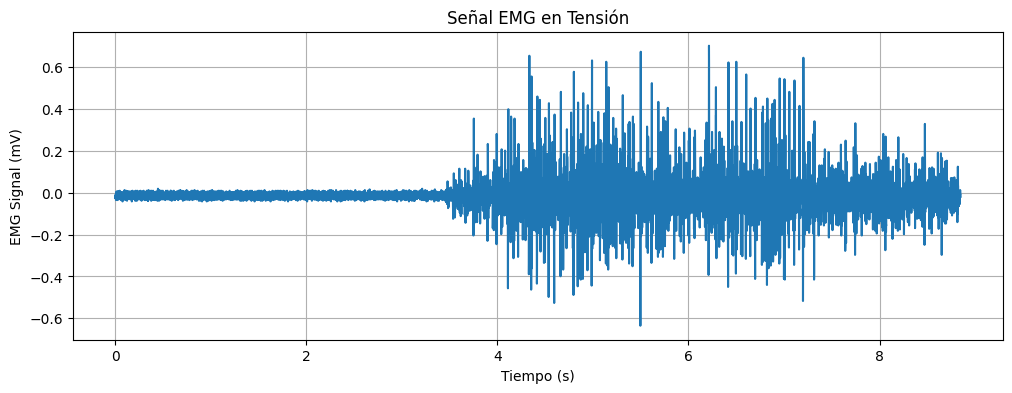

In [25]:
#Se carga la señal
array_reposo = np.genfromtxt("Tensión.txt",delimiter="	",skip_header = 2) 
valores=array_reposo[:,-2]
Fs=1000#Siendo la frecuencia de muestreo del BITalino de 1000 Hz
tiempo=np.arange(0,len(valores))/Fs
valores=(((valores/1024)-0.5)*3.3)/(1009)*1000 #Se convierte la señal a mV
#valores-=np.mean(valores)
plt.figure(figsize=[12,4])
plt.plot(tiempo, valores)
plt.ylabel('EMG Signal (mV)')
plt.xlabel('Tiempo (s)')
plt.title('Señal EMG en Tensión')
plt.grid(True)

La grabación de la señal se grabó dejando unos segundo en reposo la señal y luego se ejerció la fuerza de la tensión, debido a esto se recorta la señal

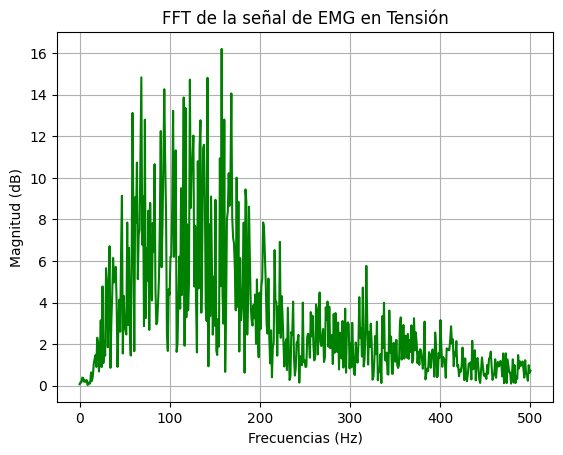

In [26]:
#Debido a que la señal comienza en 4 segundos aproximadamente, se corta la señal en ese punto
valores = valores[4 * Fs:]
tiempo= tiempo[4 * Fs:]
N=2**10 # 10 bits
valores-=np.mean(valores) #Se elimina el componente DC
X1 = np.fft.fft(valores,N)
X1 = X1[0:N//2]
X1m = np.abs(X1)
F = np.linspace(0,Fs/2,N//2)

plt.plot(F, X1m,'g')
plt.grid()
plt.title("FFT de la señal de EMG en Tensión")
plt.xlabel("Frecuencias (Hz)")
plt.ylabel("Magnitud (dB)")
plt.show()

### Filtrando la señal

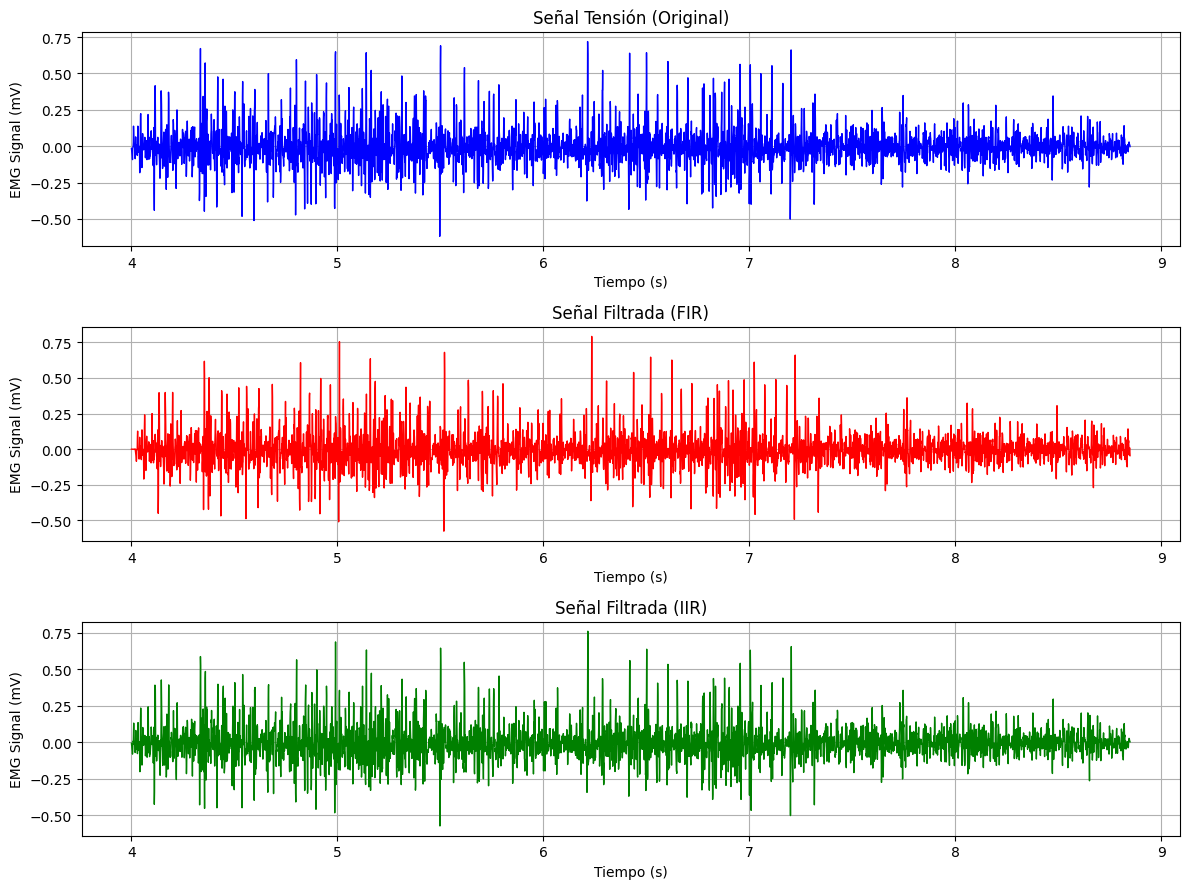

In [27]:
# Aplicar los filtros
fir_emg = lfilter(fir_filter, 1.0, valores)
iir_emg = lfilter(iir_filter[0], iir_filter[1], valores)

plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
plt.plot(tiempo, valores, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('EMG Signal (mV)')
plt.title('Señal Tensión (Original)')
plt.grid(True)


plt.subplot(3, 1, 2)
plt.plot(tiempo, fir_emg, lw=1, color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('EMG Signal (mV)')
plt.title('Señal Filtrada (FIR)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tiempo, iir_emg, lw=1, color='green')
plt.xlabel('Tiempo (s)')
plt.ylabel('EMG Signal (mV)')
plt.title('Señal Filtrada (IIR)')
plt.grid(True)
plt.tight_layout()
plt.savefig("SeñalTensión.png")
plt.show()

### Comparación en el espectro

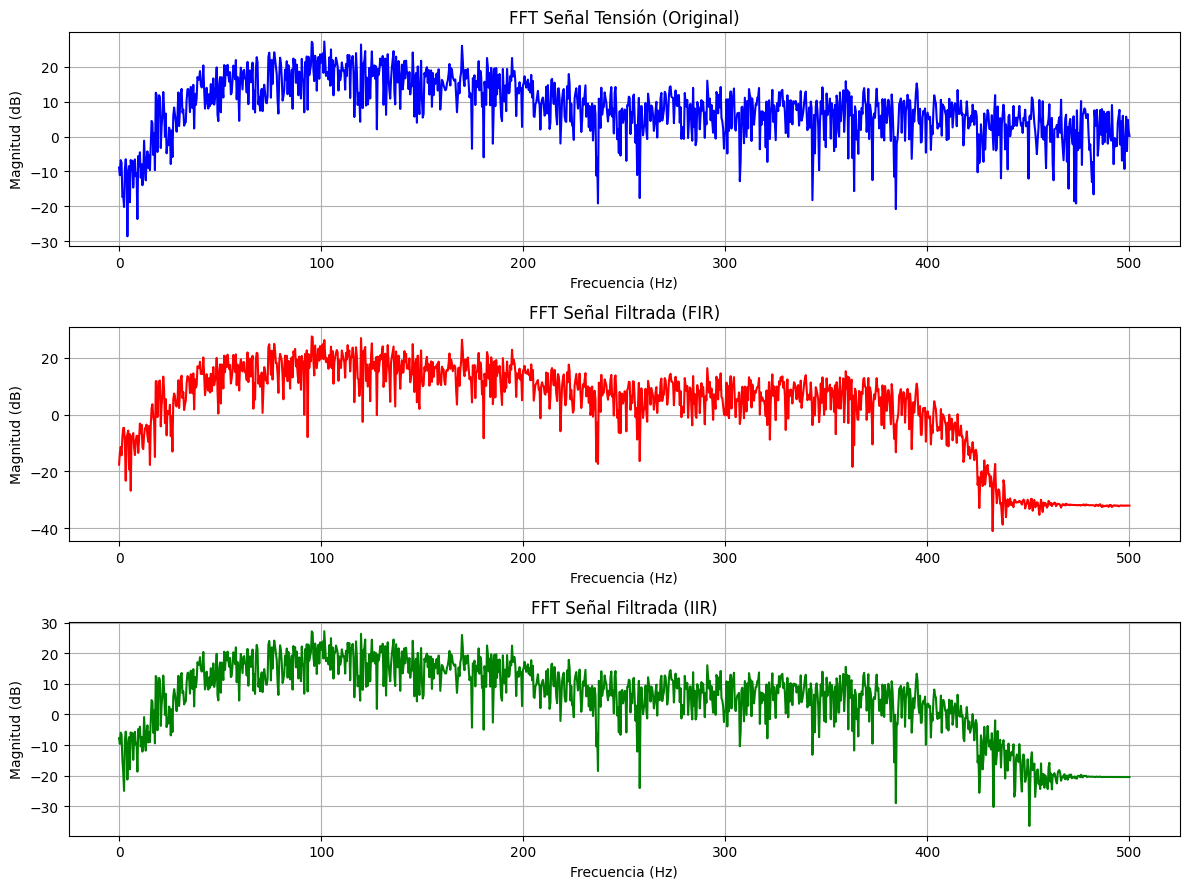

In [28]:
# Aplicar la FFT a la señal original y las señales filtradas
N = len(valores)
X_original = np.fft.fft(valores[N//2:N]) # Solo usaremos la mitad positiva de la FFT
X_original = X_original[:N//4] # Limitamos el rango de frecuencias a la mitad de la FFT
X_original_mag = np.abs(X_original)
F_original = np.linspace(0, Fs/2, len(X_original))

X_fir = np.fft.fft(fir_emg[N//2:N])
X_fir = X_fir[:N//4]
X_fir_mag = np.abs(X_fir)

X_iir = np.fft.fft(iir_emg[N//2:N])
X_iir = X_iir[:N//4]
X_iir_mag = np.abs(X_iir)
# Crear subplots para las FFT de la señal original y las señales filtradas
plt.figure(figsize=(12, 9))
# Subplot para la señal original
plt.subplot(3, 1, 1)
plt.plot(F_original, 20 * np.log10(X_original_mag),color='blue')
plt.title('FFT Señal Tensión (Original)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)
# Subplot para la FFT del FIR Filtro
plt.subplot(3, 1, 2)
plt.plot(F_original, 20 * np.log10(X_fir_mag),color='red')
plt.title('FFT Señal Filtrada (FIR)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

# Subplot para la FFT del IIR Filtro
plt.subplot(3, 1, 3)
plt.plot(F_original, 20 * np.log10(X_iir_mag), color='green')
plt.title('FFT Señal Filtrada (IIR)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()
